#CSE 252D Advance Computer Vision Mini Project Demo Notebook

### **Title:** Stable Diffusion: Image to Prompts

### **Team Members:** Sai Sree Harsha, Rohit Ramaprasad, Omkar Bhope, Yejin Jeon

In this project, we propose a novel Transformer based ensemble model for the task of predicting the text prompt given a generated image. The predicted text prompt can then be edited and used to generate new images similar to the existing one. Our proposed ensemble model uses embeddings derived from several models such as ConvNext, CLIP and BLIP, and leverages the attention mechanism to fuse these embeddings using a transformer encoder model. We train and evaluate our proposed transformer ensemble model using a large dataset of (prompt, image) pairs from DiffusionDB, and show that our model is able to generate text prompts similar to the prompts used to generate the image.

# Install required libraries

In [1]:
!pip install sentence_transformers
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install pytorch_lightning torchmetrics
!pip install clip-interrogator==0.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-adrymw9l
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-adrymw9l
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Mount Google Drive and Clone GitHub repository

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Spring 2023/CSE 252D Project/Harsha-Image-to-Prompts

/content/drive/MyDrive/Spring 2023/CSE 252D Project/Harsha-Image-to-Prompts


In [4]:
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torchvision import transforms

# Display images and ground truth prompts

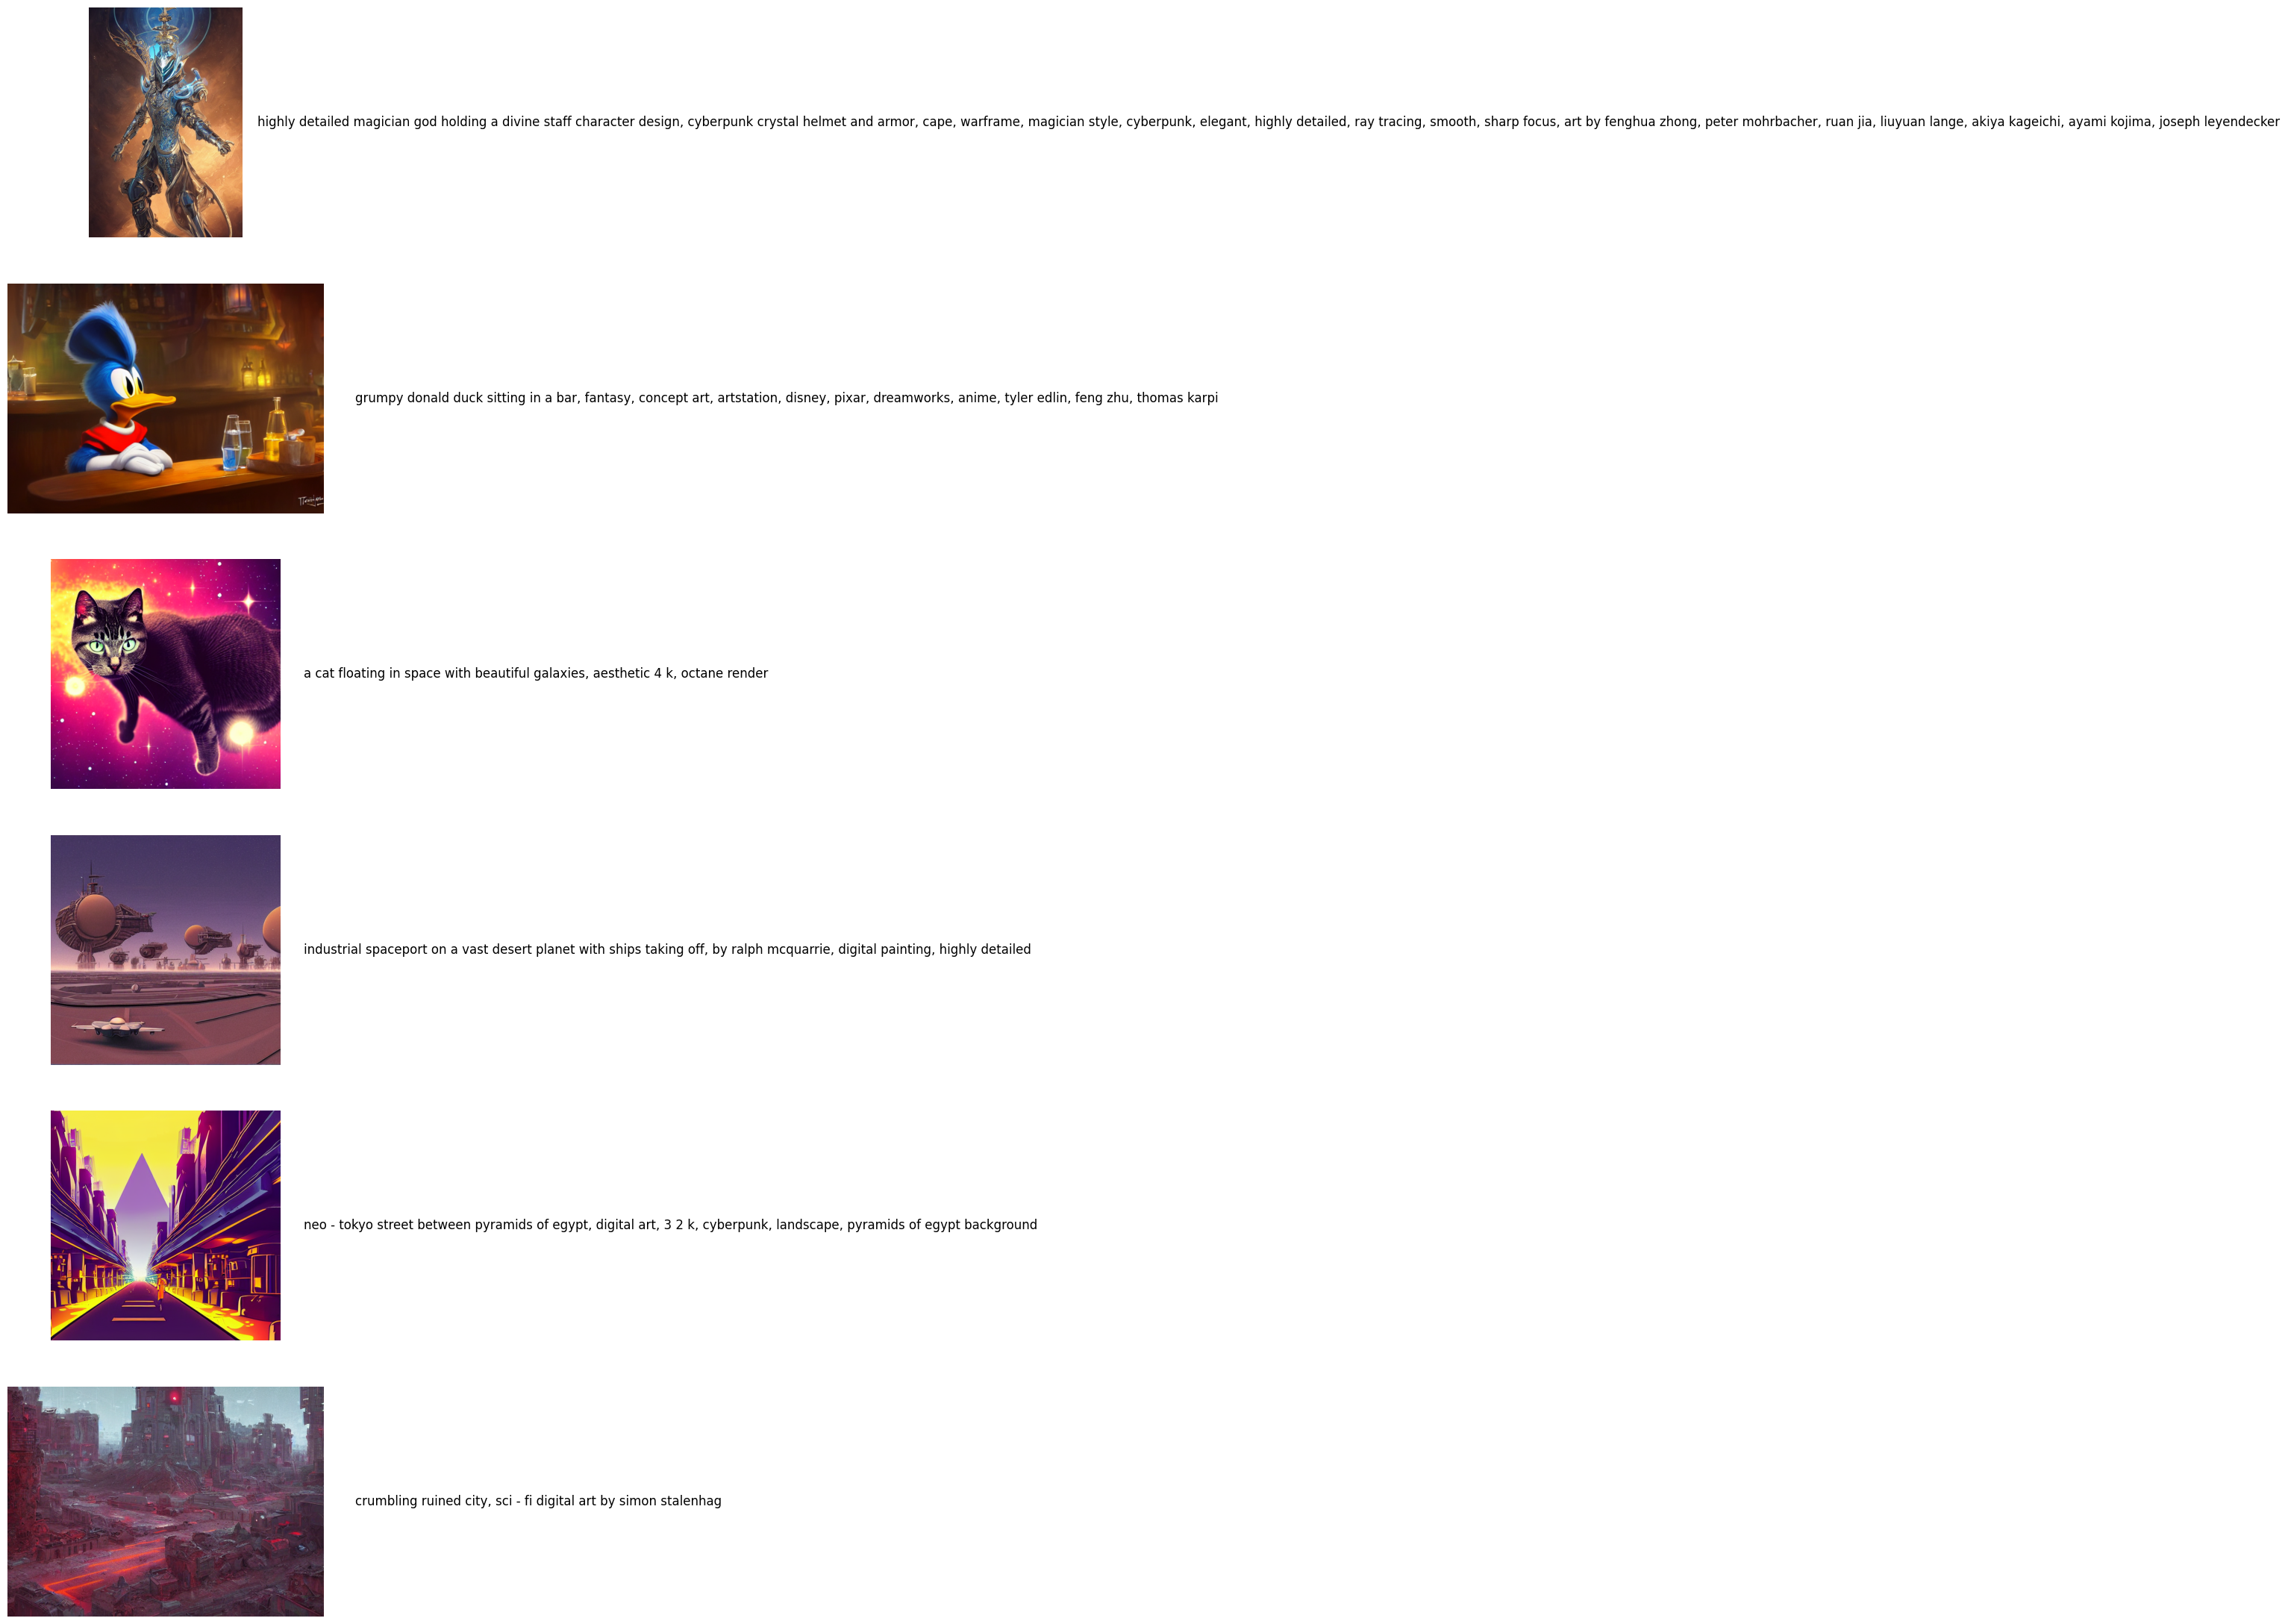

In [5]:
sample_images = sorted(glob.glob("./demo-data/images/*.png"))
prompts_df = pd.read_csv("./demo-data/prompts.csv")

plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(len(sample_images), 1, figsize=(16, 28))

for i, impath in enumerate(sample_images):
    image = Image.open(impath)
    img_id = impath.split("/")[-1]
    gt_prompt = prompts_df[prompts_df['image']==img_id]['prompt'].values[0]
    ax[i].axis('off')
    ax[i].imshow(image)
    ax[i].text(1.1, .5, gt_prompt, horizontalalignment='left', verticalalignment='center', transform=ax[i].transAxes)

# Create ground truth prompt embeddings

In [6]:
from gt_prompt_embedding_creation import create_gt_embeddings

gt_embeddings = create_gt_embeddings("./demo-data/prompts.csv")
print("\n Shape of ground text truth prompts embeddings: ", gt_embeddings.shape)


 Shape of ground text truth prompts embeddings:  (6, 384)


# Create CLIP embeddings

In [7]:
from clip_embedding_creation import create_clip_embeddings

clip_embeddings = create_clip_embeddings("./demo-data/images/*.png", batch_size=1)
print("\n Shape of CLIP image embeddings: ", clip_embeddings.shape)

100%|██████████| 6/6 [00:00<00:00, 10.90it/s]


 Shape of CLIP image embeddings:  (6, 512)


# Create ConvNext embeddings

In [8]:
from convnext_embedding_creation import create_convnext_embeddings

convnext_embeddings = create_convnext_embeddings("./demo-data/images/*.png", batch_size=1)
print("\n Shape of ConvNext image embeddings: ", convnext_embeddings.shape)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of the model checkpoint at facebook/convnext-tiny-224 were not used when initializing ConvNextModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ConvNextModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ConvNextModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 6/6 [00:00<00:00, 14.32it/s]


 Shape of ConvNext image embeddings:  (6, 768)


# Create CLIP Interrogator embeddings

In [9]:
from clip_intgtr_embedding_creation import create_clip_intgtr_embeddings

clip_intgtr_embeddings = create_clip_intgtr_embeddings("./demo-data/images/*.png")
print("\n Shape of CLIP Interrogator embeddings: ", clip_intgtr_embeddings.shape)

Loading caption model blip-large...
Loading CLIP model ViT-H-14/laion2b_s32b_b79k...
Loaded CLIP model and data in 30.05 seconds.


100%|██████████| 6/6 [00:04<00:00,  1.39it/s]



 Shape of CLIP Interrogator embeddings:  (6, 384)


# Load our Transfomer Ensemble Model weights and perform inference

In [10]:
from ensemble_model import EnsembleModel

class CFG:
    num_layers = 3
    num_heads = 8

model = EnsembleModel(CFG)
weights = torch.load("/content/drive/MyDrive/Spring 2023/Final CSE 252D Project Files/model_ckpts/10k_train_final/10k_ensemble_model.ckpt")

from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in weights['state_dict'].items():
    name = k[6:] # remove `model.`
    new_state_dict[name] = v

model.load_state_dict(new_state_dict)
model.cuda()
model.eval()

clip_embeddings = torch.tensor(clip_embeddings,dtype=torch.float32, device='cuda')
convnext_embeddings = torch.tensor(convnext_embeddings,dtype=torch.float32, device='cuda')
clip_intgtr_embeddings = torch.tensor(clip_intgtr_embeddings,dtype=torch.float32, device='cuda')

with torch.no_grad():
  out = model([clip_embeddings, convnext_embeddings, clip_intgtr_embeddings])
  print("\n Shape of ensemble model output embeddings: ", clip_intgtr_embeddings.size())


 Shape of ensemble model output embeddings:  torch.Size([6, 384])


# Find similarity of predicted embeddings with embeddings of the ground truth prompt

In [11]:
similarity = torch.nn.CosineSimilarity()
similarity_list = similarity(out, torch.tensor(gt_embeddings, device='cuda')).detach().cpu().numpy()
print("Cosine similarity for each image: ", similarity_list)
print("Mean cosine similarity: ", similarity_list.mean())

Cosine similarity for each image:  [0.98348045 0.87029755 0.65508467 0.94932604 0.593972   0.81752956]
Mean cosine similarity:  0.81161505
